<a href="http://colab.research.google.com/github/dipanjanS/nlp_workshop_odsc19/blob/master/Module05%20-%20NLP%20Applications/Project07C_XTN%20-%20Text%20Classification%20Deep%20Learning%20Sequential%20Models%20Bidirectional%20GRUs%20with%20Attention.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Text Classification - Deep Learning Sequential Models - Bidirectional GRUs with Attention

Bi-directional Models help us to capture better contextual information of sequences by going front to back and back to front of the same sequence and concatenating\averaging the contextual information from the hidden states. Also instead of just passing in the last hidden state from the LSTM\GRU we can push all the states to an attention model to attend to the most important words based on the cell states.

# GPU Test

In [1]:
!nvidia-smi

Tue Aug  6 01:45:33 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.67       Driver Version: 410.79       CUDA Version: 10.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   71C    P8    17W /  70W |      0MiB / 15079MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

# Install Dependencies

In [2]:
!pip install contractions
!pip install textsearch
!pip install tqdm
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

# Load and View Dataset

In [0]:
import pandas as pd
import numpy as np

# fix random seed for reproducibility
seed = 42
np.random.seed(seed)

In [4]:
dataset = pd.read_csv(r'https://github.com/dipanjanS/nlp_workshop_dhs18/raw/master/Unit%2011%20-%20Sentiment%20Analysis%20-%20Unsupervised%20Learning/movie_reviews.csv.bz2', compression='bz2')
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
review       50000 non-null object
sentiment    50000 non-null object
dtypes: object(2)
memory usage: 781.3+ KB


In [5]:
# take a peek at the data
dataset.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [0]:
# build train and test datasets
reviews = dataset['review'].values
sentiments = dataset['sentiment'].values

train_reviews = reviews[:35000]
train_sentiments = sentiments[:35000]

test_reviews = reviews[35000:]
test_sentiments = sentiments[35000:]

# Basic Data Pre-processing

In [0]:
import contractions
from bs4 import BeautifulSoup
import numpy as np
import re
import tqdm
import unicodedata


def strip_html_tags(text):
  soup = BeautifulSoup(text, "html.parser")
  [s.extract() for s in soup(['iframe', 'script'])]
  stripped_text = soup.get_text()
  stripped_text = re.sub(r'[\r|\n|\r\n]+', '\n', stripped_text)
  return stripped_text

def remove_accented_chars(text):
  text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
  return text

def pre_process_corpus(docs):
  norm_docs = []
  for doc in tqdm.tqdm(docs):
    doc = strip_html_tags(doc)
    doc = doc.translate(doc.maketrans("\n\t\r", "   "))
    doc = doc.lower()
    doc = remove_accented_chars(doc)
    doc = contractions.fix(doc)
    # lower case and remove special characters\whitespaces
    doc = re.sub(r'[^a-zA-Z0-9\s]', '', doc, re.I|re.A)
    doc = re.sub(' +', ' ', doc)
    doc = doc.strip()  
    norm_docs.append(doc)
  
  return norm_docs

In [8]:
%%time

norm_train_reviews = pre_process_corpus(train_reviews)
norm_test_reviews = pre_process_corpus(test_reviews)

100%|██████████| 15000/15000 [00:08<00:00, 1794.30it/s]

CPU times: user 27.9 s, sys: 145 ms, total: 28 s
Wall time: 28 s


## Data Preprocessing and formatting
 
To prepare text data for our deep learning model, we transform each review into a sequence.
Every word in the review is mapped to an integer index and thus the sentence turns into a sequence of numbers.

To perform this transformation, keras provides the ```Tokenizer```

In [9]:
import keras

t = keras.preprocessing.text.Tokenizer(oov_token='<UNK>')
# fit the tokenizer on the documents
t.fit_on_texts(norm_train_reviews)
t.word_index['<PAD>'] = 0

Using TensorFlow backend.


In [10]:
max([(k, v) for k, v in t.word_index.items()], key = lambda x:x[1]), min([(k, v) for k, v in t.word_index.items()], key = lambda x:x[1]), t.word_index['<UNK>']

(('dawgis', 175859), ('<PAD>', 0), 1)

In [0]:
train_sequences = t.texts_to_sequences(norm_train_reviews)
test_sequences = t.texts_to_sequences(norm_test_reviews)

In [12]:
print("Vocabulary size={}".format(len(t.word_index)))
print("Number of Documents={}".format(t.document_count))

Vocabulary size=175860
Number of Documents=35000


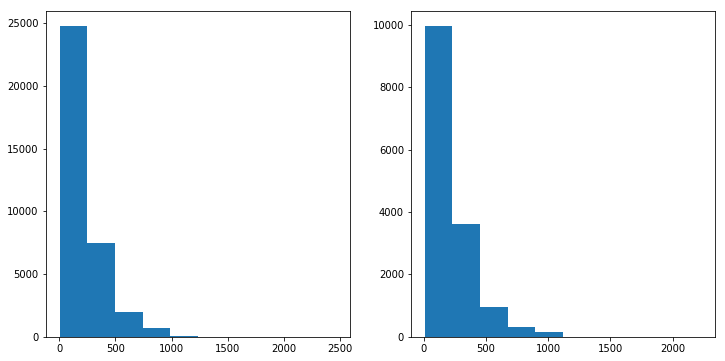

In [13]:
import matplotlib.pyplot as plt
%matplotlib inline

train_lens = [len(s) for s in train_sequences]
test_lens = [len(s) for s in test_sequences]

fig, ax = plt.subplots(1,2, figsize=(12, 6))
h1 = ax[0].hist(train_lens)
h2 = ax[1].hist(test_lens)

### Sequence Normalization

Not all reviews are of same length. To handle this difference in length of reviews, we define a maximum length.
For reviews which are smaller than this length, we pad them with zeros which longer ones are truncated

In [0]:
MAX_SEQUENCE_LENGTH = 1000

In [15]:
# pad dataset to a maximum review length in words
X_train = keras.preprocessing.sequence.pad_sequences(train_sequences, maxlen=MAX_SEQUENCE_LENGTH)
X_test = keras.preprocessing.sequence.pad_sequences(test_sequences, maxlen=MAX_SEQUENCE_LENGTH)
X_train.shape, X_test.shape

((35000, 1000), (15000, 1000))

### Encoding Labels

The dataset contains labels of the form positive/negative. The following step encodes the labels using ```sklearn's``` ```LabelEncoder```

In [0]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
num_classes=2 # positive -> 1, negative -> 0

In [0]:
y_train = le.fit_transform(train_sentiments)
y_test = le.transform(test_sentiments)

In [0]:
VOCAB_SIZE = len(t.word_index)

# Bi-directional GRU + Attention Model

## Build Model Architecture

### Attention Layer

Attention Layer focuses on attending to the most important words. We sent all the states from our GRU model into the attention model.

![](https://i.imgur.com/vbGl6Vl.png)

The attention layer produces a context vector

![](https://i.imgur.com/nZ71MVd.png)

![](https://i.imgur.com/00KyS2e.png)

In [0]:
from keras.engine.topology import Layer
from keras import backend as K


class AttentionLayer(Layer):
    
    def __init__(self, step_dim,
                 W_regularizer=None, b_regularizer=None,
                 W_constraint=None, b_constraint=None,
                 bias=True, **kwargs):
        
        """
        Keras Layer that implements an Attention mechanism for temporal data.
        Supports Masking.
        Follows the work of Raffel et al. [https://arxiv.org/abs/1512.08756]
        # Input shape
            3D tensor with shape: `(samples, steps, features)`.
        # Output shape
            2D tensor with shape: `(samples, features)`.
        :param kwargs:
        Just put it on top of an RNN Layer (GRU/LSTM/SimpleRNN) with return_sequences=True.
        The dimensions are inferred based on the output shape of the RNN.
        """
        
        self.supports_masking = True
        self.init = keras.initializers.get('glorot_uniform')

        self.W_regularizer = keras.regularizers.get(W_regularizer)
        self.b_regularizer = keras.regularizers.get(b_regularizer)

        self.W_constraint = keras.constraints.get(W_constraint)
        self.b_constraint = keras.constraints.get(b_constraint)

        self.bias = bias
        self.step_dim = step_dim
        self.features_dim = 0
        super(AttentionLayer, self).__init__(**kwargs)
        

    def build(self, input_shape):
        assert len(input_shape) == 3

        self.W = self.add_weight((input_shape[-1],),
                                 initializer=self.init,
                                 name='{}_W'.format(self.name),
                                 regularizer=self.W_regularizer,
                                 constraint=self.W_constraint)
        self.features_dim = input_shape[-1]

        if self.bias:
            self.b = self.add_weight((input_shape[1],),
                                     initializer='zero',
                                     name='{}_b'.format(self.name),
                                     regularizer=self.b_regularizer,
                                     constraint=self.b_constraint)
        else:
            self.b = None

        self.built = True
        

    def compute_mask(self, input, input_mask=None):
        # do not pass the mask to the next layers
        return None

    
    def call(self, x, mask=None):
        # TF backend doesn't support it
        # eij = K.dot(x, self.W) 
        # features_dim = self.W.shape[0]
        # step_dim = x._keras_shape[1]

        features_dim = self.features_dim
        step_dim = self.step_dim

        eij = K.reshape(K.dot(K.reshape(x, (-1, features_dim)), 
                              K.reshape(self.W, (features_dim, 1))),
                        (-1, step_dim))

        if self.bias:
            eij += self.b

        eij = K.tanh(eij)

        a = K.exp(eij)

        # apply mask after the exp. will be re-normalized next
        if mask is not None:
            # Cast the mask to floatX to avoid float64 upcasting in theano
            a *= K.cast(mask, K.floatx())

        # in some cases especially in the early stages of training the sum may be almost zero
        a /= K.cast(K.sum(a, axis=1, keepdims=True) + K.epsilon(), K.floatx())
        a = K.expand_dims(a)
        weighted_input = x * a
        
        return K.sum(weighted_input, axis=1)

    
    def compute_output_shape(self, input_shape):
        return input_shape[0],  self.features_dim
    
    
    def get_config(self):
        config = {'step_dim': self.step_dim}
        base_config = super(AttentionLayer, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

### Bi-directional GRUs

![](https://i.imgur.com/PuTHi2C.png)

![](https://i.imgur.com/ewTg3gB.png)

![](https://i.imgur.com/oaBYGeu.png)

In [20]:
EMBEDDING_DIM = 300 # dimension for dense embeddings for each token
GRU_DIM = 128 # total LSTM units

inp = keras.layers.Input(shape=(MAX_SEQUENCE_LENGTH,))
x = keras.layers.Embedding(VOCAB_SIZE, EMBEDDING_DIM, trainable=True)(inp)
x = keras.layers.Bidirectional(keras.layers.CuDNNGRU(GRU_DIM, return_sequences=True))(x)
x = AttentionLayer(MAX_SEQUENCE_LENGTH)(x)
x = keras.layers.Dense(GRU_DIM*2, activation='relu')(x)
x = keras.layers.Dropout(rate=0.2)(x)
x = keras.layers.Dense(GRU_DIM, activation='relu')(x)
x = keras.layers.Dropout(rate=0.2)(x)

outp = keras.layers.Dense(1, activation='sigmoid')(x)
# initialize the model
model = keras.models.Model(inputs=inp, outputs=outp)

# make the model parallel
#model = multi_gpu_model(model, gpus=2)
    
model.compile(loss='binary_crossentropy', optimizer=keras.optimizers.Adam(), metrics=['accuracy'])
model.summary()

W0806 01:46:37.181323 139804199487360 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0806 01:46:37.198185 139804199487360 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0806 01:46:37.201365 139804199487360 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0806 01:46:38.180671 139804199487360 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:133: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W0806 01:46:38.190708 

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 1000)              0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 1000, 300)         52758000  
_________________________________________________________________
bidirectional_1 (Bidirection (None, 1000, 256)         330240    
_________________________________________________________________
attention_layer_1 (Attention (None, 256)               1256      
_________________________________________________________________
dense_1 (Dense)              (None, 256)               65792     
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               32896     
__________

## Train Model

In [21]:
batch_size = 100
model.fit(X_train, y_train, epochs=2, batch_size=batch_size, 
          shuffle=True, validation_split=0.1, verbose=1)

Train on 31500 samples, validate on 3500 samples
Epoch 1/2
31500/31500 [==============================] - 73s 2ms/step - loss: 0.4235 - acc: 0.7875 - val_loss: 0.2663 - val_acc: 0.8903
Epoch 2/2
31500/31500 [==============================] - 69s 2ms/step - loss: 0.1581 - acc: 0.9422 - val_loss: 0.2816 - val_acc: 0.8923


## Evaluate Model Performance

In [22]:
# Final evaluation of the model
scores = model.evaluate(X_test, y_test, verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

15000/15000 [==============================] - 19s 1ms/step
Accuracy: 89.66%


In [25]:
prediction_probs = model.predict(X_test, verbose=1).ravel()
predictions = [1 if prob > 0.5 else 0 for prob in prediction_probs]
predictions[:10]

15000/15000 [==============================] - 19s 1ms/step


[0, 1, 0, 1, 1, 0, 1, 1, 0, 1]

In [26]:
predictions = ['positive' if item == 1 else 'negative' for item in predictions]
predictions[:10]

['negative',
 'positive',
 'negative',
 'positive',
 'positive',
 'negative',
 'positive',
 'positive',
 'negative',
 'positive']

In [27]:
from sklearn.metrics import confusion_matrix, classification_report

labels = ['negative', 'positive']
print(classification_report(test_sentiments, predictions))
pd.DataFrame(confusion_matrix(test_sentiments, predictions), index=labels, columns=labels)

              precision    recall  f1-score   support

    negative       0.91      0.87      0.89      7490
    positive       0.88      0.92      0.90      7510

    accuracy                           0.90     15000
   macro avg       0.90      0.90      0.90     15000
weighted avg       0.90      0.90      0.90     15000



,negative,positive
negative,6550,940
positive,611,6899


# Stacked LSTM Model

## Build Model Architecture

In [28]:
EMBEDDING_DIM = 300 # dimension for dense embeddings for each token
GRU_DIM = 128 # total LSTM units

inp = keras.layers.Input(shape=(MAX_SEQUENCE_LENGTH,))
x = keras.layers.Embedding(VOCAB_SIZE, EMBEDDING_DIM, trainable=True)(inp)
x = keras.layers.Bidirectional(keras.layers.CuDNNGRU(GRU_DIM*2, return_sequences=True))(x)
x = keras.layers.Bidirectional(keras.layers.CuDNNGRU(GRU_DIM, return_sequences=True))(x)
x = AttentionLayer(MAX_SEQUENCE_LENGTH)(x)
x = keras.layers.Dense(GRU_DIM*2, activation='relu')(x)
x = keras.layers.Dropout(rate=0.2)(x)
x = keras.layers.Dense(GRU_DIM, activation='relu')(x)
x = keras.layers.Dropout(rate=0.2)(x)

outp = keras.layers.Dense(1, activation='sigmoid')(x)
# initialize the model
model2 = keras.models.Model(inputs=inp, outputs=outp)

# make the model parallel
#model = multi_gpu_model(model, gpus=2)
    
model2.compile(loss='binary_crossentropy', optimizer=keras.optimizers.Adam(), metrics=['accuracy'])
model2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 1000)              0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 1000, 300)         52758000  
_________________________________________________________________
bidirectional_2 (Bidirection (None, 1000, 512)         857088    
_________________________________________________________________
bidirectional_3 (Bidirection (None, 1000, 256)         493056    
_________________________________________________________________
attention_layer_2 (Attention (None, 256)               1256      
_________________________________________________________________
dense_4 (Dense)              (None, 256)               65792     
_________________________________________________________________
dropout_3 (Dropout)          (None, 256)               0         
__________

## Train Model

In [29]:
batch_size = 100
model2.fit(X_train, y_train, epochs=2, batch_size=batch_size, 
           shuffle=True, validation_split=0.1, verbose=1)

Train on 31500 samples, validate on 3500 samples
Epoch 1/2
31500/31500 [==============================] - 184s 6ms/step - loss: 0.3856 - acc: 0.8070 - val_loss: 0.2457 - val_acc: 0.8937
Epoch 2/2
31500/31500 [==============================] - 182s 6ms/step - loss: 0.1324 - acc: 0.9517 - val_loss: 0.2669 - val_acc: 0.8911


## Evaluate Model Performance

In [30]:
# Final evaluation of the model
scores = model2.evaluate(X_test, y_test, verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

15000/15000 [==============================] - 49s 3ms/step
Accuracy: 89.63%


In [31]:
prediction_probs = model2.predict(X_test, verbose=1).ravel()
predictions = [1 if prob > 0.5 else 0 for prob in prediction_probs]
predictions[:10]

15000/15000 [==============================] - 49s 3ms/step


[0, 1, 0, 1, 1, 0, 1, 1, 1, 1]

In [32]:
predictions = ['positive' if item == 1 else 'negative' for item in predictions]
predictions[:10]

['negative',
 'positive',
 'negative',
 'positive',
 'positive',
 'negative',
 'positive',
 'positive',
 'positive',
 'positive']

In [33]:
labels = ['negative', 'positive']
print(classification_report(test_sentiments, predictions))
pd.DataFrame(confusion_matrix(test_sentiments, predictions), index=labels, columns=labels)

              precision    recall  f1-score   support

    negative       0.88      0.92      0.90      7490
    positive       0.91      0.88      0.89      7510

    accuracy                           0.90     15000
   macro avg       0.90      0.90      0.90     15000
weighted avg       0.90      0.90      0.90     15000



,negative,positive
negative,6858,632
positive,924,6586


# Take Home: Transfer Learning with Pre-trained Embeddings

Grab pre-trained embeddings from:

- [FastText](https://fasttext.cc/docs/en/english-vectors.html)
- [Paragram](https://drive.google.com/file/d/0B9w48e1rj-MOck1fRGxaZW1LU2M/view?usp=sharing)

Following tutorial [here](https://github.com/fabric8-analytics/openshift-probable-vulnerabilities/blob/master/notebooks/modeling/deep_learning_models/phase1_baseline_seq_models/GoKube%20Phase1%20-%205%20-%20Security%20vs%20Non-Security%20Modeling.ipynb) build your own models! 